## Python Validation (v1.1 Time-split)

이 노트북은 v1.1(Time-split: **관측 0–60d → 성과 60–180d**)의 핵심 결과를  
BigQuery Data Mart **DM_timesplit_60_180_final** CSV export 데이터를 기반으로 **Python에서 재현**합니다.

- 입력 데이터: time_split_min.csv (export from ecommerce_dm.DM_timesplit_60_180_final)

**목표**
- Python에서 동일 KPI를 다시 집계해 SQL Story 결과의 **재현성(reproducibility)**을 확인
- SQL 표(평균 중심)만으로는 보이기 어려운 포인트를 시각화로 보강  
  - Activation stage × Consistency segment **heatmap**
  - 구매자(buyers-only) 기준 **log1p(revenue_60_180)** **분포(“평균의 함정” 회피)**
- Bootstrap CI는 **C1 vs C5 구매율 차이**를 1회만 수행해 결과의 안정성을 **sanity-check**하는 용도  


**산출물 저장 경로**
- `docs/results/figures(python)/`


In [1]:
import pandas as pd
import numpy as np

# 1) CSV 로드
path = "time_split_min.csv"
df = pd.read_csv(path)

# 2) 데이터 컬럼확인
print("shape:", df.shape)
print("columns:", df.columns.tolist())

# 3) 타입 정리 (bool 컬럼이 문자열로 들어온 경우 대비)
assert df["has_purchase_60_180"].dtype == "bool"
assert df["retention_last_week_180d"].dtype == "bool"

# 4) 핵심 결측률만 확인
check_cols = [
    "activation_stage_14d",
    "consistency_segment_obs_60d",
    "revenue_60_180",
    "has_purchase_60_180",
    "retention_last_week_180d",
    "intervisit_cv_obs_60d",
    "consistency_score_obs_60d",
]
check_cols = [c for c in check_cols if c in df.columns]
print("\nNA rate (key cols):")
print(df[check_cols].isna().mean().sort_values(ascending=False))

print("\ndtypes (key cols):")
print(df[check_cols].dtypes)

df.head(5)

shape: (30000, 11)
columns: ['user_id', 'signup_date', 'activation_stage_14d', 'consistency_segment_obs_60d', 'consistency_score_obs_60d', 'active_days_obs_60d', 'intervisit_cv_obs_60d', 'revenue_60_180', 'has_purchase_60_180', 'orders_60_180', 'retention_last_week_180d']

NA rate (key cols):
consistency_score_obs_60d      0.1308
intervisit_cv_obs_60d          0.1308
retention_last_week_180d       0.0000
has_purchase_60_180            0.0000
revenue_60_180                 0.0000
consistency_segment_obs_60d    0.0000
activation_stage_14d           0.0000
dtype: float64

dtypes (key cols):
activation_stage_14d            object
consistency_segment_obs_60d     object
revenue_60_180                 float64
has_purchase_60_180               bool
retention_last_week_180d          bool
intervisit_cv_obs_60d          float64
consistency_score_obs_60d      float64
dtype: object


,user_id,signup_date,activation_stage_14d,consistency_segment_obs_60d,consistency_score_obs_60d,active_days_obs_60d,intervisit_cv_obs_60d,revenue_60_180,has_purchase_60_180,orders_60_180,retention_last_week_180d
0,18169,2022-01-18,A1_view,C1,NaN,1,NaN,0.0,False,0,False
1,4118,2022-01-18,A1_view,C5,2.042011,16,0.657586,0.0,False,0,False
2,18134,2022-01-18,A1_view,C5,1.537317,12,0.572799,0.0,False,0,True
3,16352,2022-01-18,A1_view,C5,1.297793,15,0.848839,0.0,False,0,False
4,12694,2022-01-18,A0_no_activity,C4,1.094783,9,0.531213,0.0,False,0,False


- consistency_score/intervisit_cv NA는 관측(0–60) 내 세션 2회 미만 등으로
  inter-visit 계산 불가한 유저에서 발생하여,segment는 SQL에서 NA를 C1로 보수 처리했기 때문에 분석에 영향을 주지않음.

In [2]:
# C1~C5 세그먼트별 KPI 집계 (원본/그래프용)
seg_kpi = (
    df.groupby("consistency_segment_obs_60d", as_index=False)
      .agg(
          n=("user_id", "count"),
          avg_revenue_60_180=("revenue_60_180", "mean"),
          purchase_rate_60_180=("has_purchase_60_180", "mean"),
          retention_rate_180=("retention_last_week_180d", "mean"),
      )
)

# C1~C5 순서 정렬
seg_kpi["seg_num"] = seg_kpi["consistency_segment_obs_60d"].str.replace("C", "", regex=False).astype(int)
seg_kpi = seg_kpi.sort_values("seg_num").drop(columns=["seg_num"])


In [3]:
# 요약 테이블 
seg_kpi_print = seg_kpi.copy()
seg_kpi_print["purchase_rate_60_180"] = (seg_kpi_print["purchase_rate_60_180"]*100).round(2)
seg_kpi_print["retention_rate_180"] = (seg_kpi_print["retention_rate_180"]*100).round(2)
seg_kpi_print["avg_revenue_60_180"] = seg_kpi_print["avg_revenue_60_180"].round(0).astype(int)

seg_kpi_print


,consistency_segment_obs_60d,n,avg_revenue_60_180,purchase_rate_60_180,retention_rate_180
0,C1,6000,10247,4.92,25.72
1,C2,6000,31876,15.52,42.23
2,C3,6000,51725,21.90,49.57
3,C4,6000,77659,29.13,59.57
4,C5,6000,142561,46.68,76.67


In [4]:
# Activation stage × Consistency segment 조합별 KPI (히트맵 원본)
mat_kpi = (
    df.groupby(["activation_stage_14d", "consistency_segment_obs_60d"], as_index=False)
      .agg(
          n=("user_id", "count"),
          avg_revenue_60_180=("revenue_60_180", "mean"),
          purchase_rate_60_180=("has_purchase_60_180", "mean"),
          retention_rate_180=("retention_last_week_180d", "mean"),
      )
)

# 행/열 순서 고정 (A0→A5, C1→C5)
stage_order = ["A0_no_activity","A1_view","A2_click","A3_add_to_cart","A4_checkout","A5_purchase"]
mat_kpi["activation_stage_14d"] = pd.Categorical(mat_kpi["activation_stage_14d"], categories=stage_order, ordered=True)
mat_kpi["seg_num"] = mat_kpi["consistency_segment_obs_60d"].str.replace("C","", regex=False).astype(int)
mat_kpi = mat_kpi.sort_values(["activation_stage_14d","seg_num"]).drop(columns=["seg_num"])


In [5]:
# Heat Map 그리기전 Pivot QA

# purchase rate matrix (0~1 비율)
heat_pr = mat_kpi.pivot(
    index="activation_stage_14d",
    columns="consistency_segment_obs_60d",
    values="purchase_rate_60_180"
)

# avg revenue matrix
heat_rev = mat_kpi.pivot(
    index="activation_stage_14d",
    columns="consistency_segment_obs_60d",
    values="avg_revenue_60_180"
)

#print("=== purchase_rate matrix ===")
#print((heat_pr*100).round(2))  # %로 보기

#print("\n=== avg_revenue matrix ===")
#print(heat_rev.round(2))


In [6]:
# Figure 저장 
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("figures(python)")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str, dpi: int = 180):

    plt.savefig(FIG_DIR / name, dpi=dpi, bbox_inches="tight")


**Heatmap (Purchase rate, 60–180d)**  
Activation stage(0–14d)와 Consistency(C1–C5)를 교차해, 60–180d 구매율이 두 축에서 어떻게 달라지는지 한 번에 확인한다.


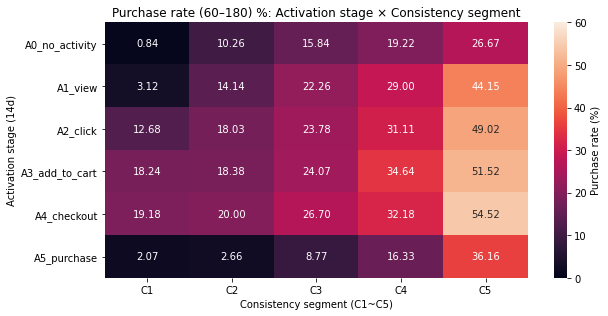

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# purchase rate (%)
mat = (heat_pr * 100).round(2)

plt.figure(figsize=(9, 4.5))
ax = sns.heatmap(
    mat,
    annot=True, fmt=".2f",
    vmin=0, vmax=60,                 #  색 범위 고정 (0~60%)
    cbar_kws={"label": "Purchase rate (%)"}
)

plt.title("Purchase rate (60–180) %: Activation stage × Consistency segment")
plt.xlabel("Consistency segment (C1~C5)")
plt.ylabel("Activation stage (14d)")
plt.tight_layout()

savefig("fig_heatmap_purchase_rate_60_180_by_activation_x_consistency_v1_1.png.png", dpi=180)  
plt.show()


**Retention (day 174–180, 180d)**  
관측 구간(0–60d)에서 정의한 Consistency(C1–C5)가 성과 구간의 장기 유지(180d 리텐션)와 어떻게 연결되는지, 세그먼트별 추세(gradient)를 라인으로 간단히 확인한다.

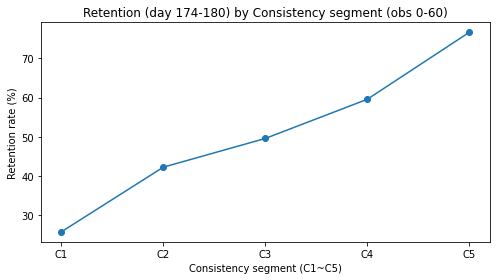

In [8]:
import matplotlib.pyplot as plt

x = seg_kpi["consistency_segment_obs_60d"]
y = seg_kpi["retention_rate_180"] * 100  # 0~1 -> %

plt.figure(figsize=(7, 4))
plt.plot(x, y, marker="o")
plt.title("Retention (day 174-180) by Consistency segment (obs 0-60)")
plt.xlabel("Consistency segment (C1~C5)")
plt.ylabel("Retention rate (%)")
plt.tight_layout()
savefig("fig_line_retention_174_180_by_consistency_segment_v1_1.png", dpi=180)
plt.show()


**Distribution (buyers-only, log1p revenue)**  
평균(average)만으로는 소수의 고액 구매자(outlier)에 의해 왜곡될 수 있어, 구매자(buyers)만 대상으로 **log1p(revenue_60_180)** 분포를 세그먼트별로 비교한다.  
→ C1~C5 간 “중앙값”뿐 아니라 분산/꼬리(variance & tail) 차이를 함께 확인해 mean trap을 회피한다.


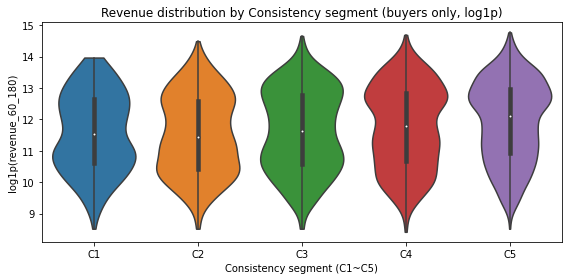

In [9]:
# 1) buyers-only + log1p 변환
order = ["C1", "C2", "C3", "C4", "C5"]
buyers = df.loc[df["revenue_60_180"] > 0, ["consistency_segment_obs_60d", "revenue_60_180"]].copy()

buyers["consistency_segment_obs_60d"] = pd.Categorical(
    buyers["consistency_segment_obs_60d"], categories=order, ordered=True
)
buyers["log1p_rev_60_180"] = np.log1p(buyers["revenue_60_180"])

# 2) violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(
    data=buyers,
    x="consistency_segment_obs_60d",
    y="log1p_rev_60_180",
    order=order,
    inner="box",
    cut=0,
    scale="width"
)

plt.title("Revenue distribution by Consistency segment (buyers only, log1p)")
plt.xlabel("Consistency segment (C1~C5)")
plt.ylabel("log1p(revenue_60_180)")
plt.tight_layout()

# 3) save
savefig("fig_violin_log1p_revenue_60_180_buyers_only_by_consistency_segment_v1_1.png",
            dpi=180)
plt.show()


**Bootstrap CI (C1 vs C5 구매율 차이, 60–180d)**  
C1과 C5의 **purchase_rate_60_180** 차이를 **percentage point(pp)** 기준으로 계산하고,  
부트스트랩(재표본추출)로 **95% 신뢰구간**을 추정해 효과 크기와 불확실성을 함께 확인한다.


In [10]:
import numpy as np

# 1) 비교할 두 그룹 추출
g1 = df.loc[df["consistency_segment_obs_60d"]=="C1", "has_purchase_60_180"].astype(int).values
g5 = df.loc[df["consistency_segment_obs_60d"]=="C5", "has_purchase_60_180"].astype(int).values

# 2) 관측 차이(percentage point)
obs_diff_pp = (g5.mean() - g1.mean()) * 100

# 3) Bootstrap
rng = np.random.default_rng(42)
B = 5000  
boot = np.empty(B)

n1, n5 = len(g1), len(g5)

for b in range(B):
    s1 = rng.choice(g1, size=n1, replace=True)
    s5 = rng.choice(g5, size=n5, replace=True)
    boot[b] = (s5.mean() - s1.mean()) * 100  # pp

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])

print(f"C1 purchase_rate_60_180: {g1.mean()*100:.2f}% (n={n1})")
print(f"C5 purchase_rate_60_180: {g5.mean()*100:.2f}% (n={n5})")
print(f"Diff (C5 - C1): {obs_diff_pp:.2f} pp")
print(f"95% bootstrap CI: [{ci_low:.2f}, {ci_high:.2f}] pp")


C1 purchase_rate_60_180: 4.92% (n=6000)
C5 purchase_rate_60_180: 46.68% (n=6000)
Diff (C5 - C1): 41.77 pp
95% bootstrap CI: [40.43, 43.10] pp
